<a href="https://colab.research.google.com/github/mmmylj/colab_DL/blob/master/%E2%80%9CTF_CNN_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=of

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import tensorflow as tf
import pylab
import os
import numpy as np
from six.moves import xrange

随机处理图片方法

In [0]:
#随机裁剪     
#     distorted_image = tf.random_crop(reshaped_image, [height, width, 3])

#随机水平翻转     
#     distorted_image = tf.image.random_flip_left_right(distorted_image)

#随机图片亮度
#     distorted_image = tf.image.random_brightness(distorted_image,
#随机图片对比度                                                  max_delta=63)
#     distorted_image = tf.image.random_contrast(distorted_image,
#                                                lower=0.2, upper=1.8)

#减去均值，除以方差，图片标准化
#     float_image = tf.image.per_image_standardization(distorted_image)

queue 方法读取 cifar数据集

In [0]:
def _generate_image_and_label_batch(image, label, min_queue_examples,
                                    batch_size, shuffle):

  # Create a queue that shuffles the examples, and then
  # read 'batch_size' images + labels from the example queue.
  num_preprocess_threads = 16
  if shuffle:
    images, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        num_threads=num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size,
        min_after_dequeue=min_queue_examples)
  else:
    images, label_batch = tf.train.batch(
        [image, label],
        batch_size=batch_size,
        num_threads=num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size)
      # Display the training images in the visualizer.
  tf.summary.image('images', images)

  return images, tf.reshape(label_batch, [batch_size])

In [6]:
#data_dir = ['drive/cifar_10_database/data_batch_%d.bin' %i  for i in xrange(1, 6)]
data_dir = ['drive/cifar_10_database/data_batch_1.bin' ]
print (data_dir)

#duilde filename equaue
filename_equaue = tf.train.string_input_producer(data_dir)
label_bytes = 1
height = 32
width = 32
depth = 3
image_bytes= 32*32*3
reader = tf.FixedLengthRecordReader(image_bytes + label_bytes)
key , value = reader.read(filename_equaue)
record_bytes = tf.decode_raw(value, tf.uint8)
label = tf.cast(
      tf.strided_slice(record_bytes, [0], [label_bytes]), tf.int32)
depth_major = tf.reshape(
      tf.strided_slice(record_bytes, [label_bytes],
                       [label_bytes + image_bytes]),
      [depth, height, width])

uint8image = tf.transpose(depth_major, [1, 2, 0])
reshaped_image = tf.cast(uint8image, tf.float32)
height = 32
width = 32
resized_image = tf.image.resize_image_with_crop_or_pad(reshaped_image,
                                                           height, width)
# Subtract off the mean and divide by the variance of the pixels.
float_image = tf.image.per_image_standardization(resized_image)

# Set the shapes of tensors.
float_image.set_shape([height, width, 3])
label.set_shape([1])
num_examples_per_epoch = 50000
# Ensure that the random shuffling has good mixing properties.
min_fraction_of_examples_in_queue = 0.4
min_queue_examples = int(num_examples_per_epoch *
                         min_fraction_of_examples_in_queue)


['drive/cifar_10_database/data_batch_1.bin']
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 [[[-2.6304090e-01 -2.9606342e-01 -1.9699585e-01]
  [ 4.3043208e-01  2.9834199e-01  2.9834199e-01]
  [ 1.8834231e+00  1.5201753e+00  1.3220402e+00]
  ...
  [-7.5837874e-01 -1.0886040e+00 -1.2206941e+00]
  [ 2.9834199e-01  1.1392811e-03 -3.9513099e-01]
  [ 5.9554470e-01  2.3229694e-01 -1.6397333e-01]]

 [[-1.5178968e+00 -1.4848742e+00 -1.3527842e+00]
  [-7.9140127e-01 -8.2442379e-01 -6.2628865e-01]
  [ 5.2949965e-01  1.9927442e-01  6.7184329e-02]
  ...
  [ 8.5972488e-01  5.6252217e-01 -1.9699585e-01]
  [ 1.0248375e+00  7.6065731e-01 -9.7928286e-02]
  [ 9.2576993e-01  6.2856722e-01 -2.3001838e-01]]

 [[-1.2206941e+00 -1.3527842e+00 -1.3527842e+00]
  [-1.3527842e+00 -1.3527842e+00 -1.1876715e+00]
  [-8.2442379e-01 -8.5744631e-01 -5.6024361e-01]
  ...
  [ 1.2559952e+00  7.9367983e-01 -9.7928286e-02]
  [ 1.1239051e+00  6.2856722e-01 -1.9699585e-01]
  [ 1.2559952e+00  7.2763479e-01 -9.7928286e-02]]

 ...

 [[ 6.9461226e-01  5.6252217e-01 -6.5931118e-01]
  [ 5.2949965e-01  3.3136451e-01 -9.2

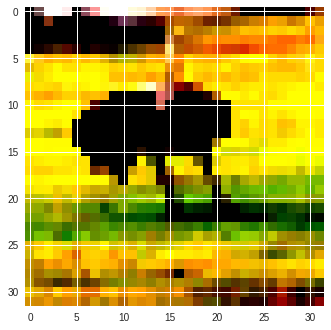

In [9]:
batch_size = 128
images_test, labels_test = _generate_image_and_label_batch(float_image, label,
                                         min_queue_examples, batch_size,
                                         shuffle=False)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
tf.train.start_queue_runners()
image_batch, label_batch = sess.run([images_test, labels_test])
print('\n', image_batch[0])
print('\n', label_batch[0])
pylab.imshow(image_batch[0])
pylab.show()